In [1]:
# ==== Package Check & Auto-Install ==========================================
import importlib
import sys
import subprocess

def install_if_missing(pkg_name, import_name=None):
    import_name = import_name or pkg_name
    try:
        importlib.import_module(import_name)
        print(f"✓ {pkg_name} already installed")
    except ImportError:
        print(f"⚠ {pkg_name} not found — installing…")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])
        print(f"✔ Installed {pkg_name} successfully")

required_packages = [
    ("matplotlib", "matplotlib"),
    ("numpy", "numpy"),
    ("pandas", "pandas"),
    ("seaborn", "seaborn"),
    ("statsmodels", "statsmodels"),
    ("scikit-learn", "sklearn"),
    ("category_encoders", "category_encoders")
]

for pkg, import_name in required_packages:
    install_if_missing(pkg, import_name)

# ==== Imports ==============================================================

# hide warnings to keep printout clean
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["PANDAS_IGNORE_BOTTLENECK"] = "1"
import numpy as np
import pandas as pd
import seaborn as sns
import math
import statsmodels.formula.api as smf
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

✓ matplotlib already installed
✓ numpy already installed
✓ pandas already installed
✓ seaborn already installed
✓ statsmodels already installed
✓ scikit-learn already installed
✓ category_encoders already installed


# Data Cleaning

In [2]:
df = pd.read_csv('data/rideshare_kaggle.csv')

# select variables needed for this project
selected_vars = [
    "id", "price", "distance", "cab_type", "name",
    "timestamp", "hour", "day", "source", "destination",
    "temperature", "precipIntensity", "precipProbability", "cloudCover",
    "surge_multiplier"
]

df = df[selected_vars].copy()
df.head()

,id,price,distance,cab_type,name,timestamp,hour,day,source,destination,temperature,precipIntensity,precipProbability,cloudCover,surge_multiplier
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,5.0,0.44,Lyft,Shared,1.544953e+09,9,16,Haymarket Square,North Station,42.34,0.0000,0.0,0.72,1.0
1,4bd23055-6827-41c6-b23b-3c491f24e74d,11.0,0.44,Lyft,Lux,1.543284e+09,2,27,Haymarket Square,North Station,43.58,0.1299,1.0,1.00,1.0
2,981a3613-77af-4620-a42a-0c0866077d1e,7.0,0.44,Lyft,Lyft,1.543367e+09,1,28,Haymarket Square,North Station,38.33,0.0000,0.0,0.03,1.0
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,26.0,0.44,Lyft,Lux Black XL,1.543554e+09,4,30,Haymarket Square,North Station,34.38,0.0000,0.0,0.00,1.0
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,9.0,0.44,Lyft,Lyft XL,1.543463e+09,3,29,Haymarket Square,North Station,37.44,0.0000,0.0,0.44,1.0


In [3]:
# rename the original day to day_of_month
df['day_of_month'] = df['day'].astype(int)

# fix timestamp and create proper day variables
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

df["month_name"] = df["datetime"].dt.month_name()  # January, February, ...
df["day_of_week"] = df["datetime"].dt.day_name()  # Monday, Tuesday, ...


# create a new binary indicator for is_weekend
df['is_weekend'] = df['day_of_week'].isin(["Saturday", "Sunday"])

# remove variables not needed
df = df.drop(columns=["day", "timestamp", "datetime"])

df.head()

,id,price,distance,cab_type,name,hour,source,destination,temperature,precipIntensity,precipProbability,cloudCover,surge_multiplier,day_of_month,month_name,day_of_week,is_weekend
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,5.0,0.44,Lyft,Shared,9,Haymarket Square,North Station,42.34,0.0000,0.0,0.72,1.0,16,December,Sunday,True
1,4bd23055-6827-41c6-b23b-3c491f24e74d,11.0,0.44,Lyft,Lux,2,Haymarket Square,North Station,43.58,0.1299,1.0,1.00,1.0,27,November,Tuesday,False
2,981a3613-77af-4620-a42a-0c0866077d1e,7.0,0.44,Lyft,Lyft,1,Haymarket Square,North Station,38.33,0.0000,0.0,0.03,1.0,28,November,Wednesday,False
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,26.0,0.44,Lyft,Lux Black XL,4,Haymarket Square,North Station,34.38,0.0000,0.0,0.00,1.0,30,November,Friday,False
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,9.0,0.44,Lyft,Lyft XL,3,Haymarket Square,North Station,37.44,0.0000,0.0,0.44,1.0,29,November,Thursday,False


In [4]:
# General info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 693071 non-null  object 
 1   price              637976 non-null  float64
 2   distance           693071 non-null  float64
 3   cab_type           693071 non-null  object 
 4   name               693071 non-null  object 
 5   hour               693071 non-null  int64  
 6   source             693071 non-null  object 
 7   destination        693071 non-null  object 
 8   temperature        693071 non-null  float64
 9   precipIntensity    693071 non-null  float64
 10  precipProbability  693071 non-null  float64
 11  cloudCover         693071 non-null  float64
 12  surge_multiplier   693071 non-null  float64
 13  day_of_month       693071 non-null  int64  
 14  month_name         693071 non-null  object 
 15  day_of_week        693071 non-null  object 
 16  is

In [5]:
# Shape
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 693071, Columns: 17


In [6]:
# Check for duplicates
print(f"Duplicated rows: {df.duplicated().sum()}")

Duplicated rows: 0


In [7]:
# number of missing values
df.isna().sum().sort_values(ascending=False).head()

price              55095
id                     0
precipIntensity        0
day_of_week            0
month_name             0
dtype: int64

# EDA

## Outcome Variable Check

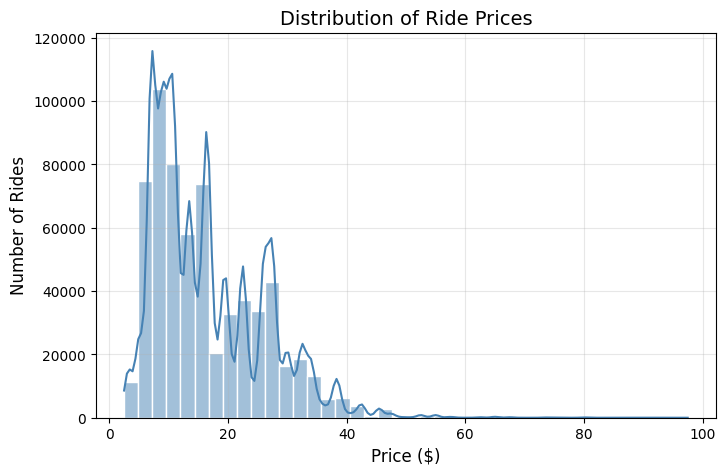

In [8]:
# distribution of price (original), with na values removed
prices = df['price'].dropna()

plt.figure(figsize=(8,5))
sns.histplot(prices, bins=40, kde=True, color='steelblue', edgecolor='white')

plt.title('Distribution of Ride Prices', fontsize=14)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Number of Rides', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

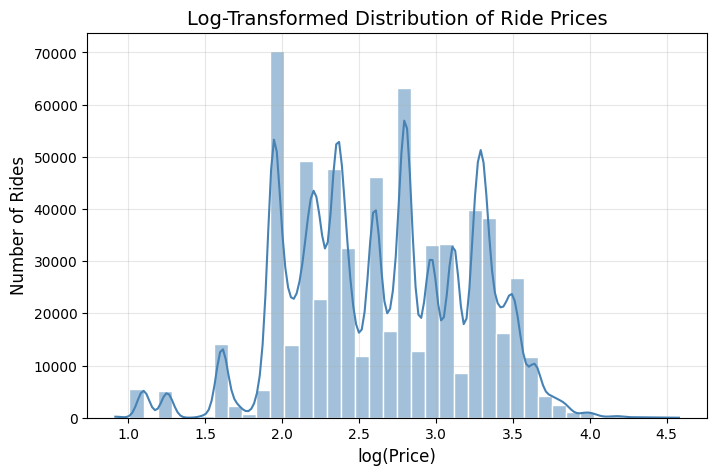

In [9]:
# distribution of price (transformed), with na values removed
# Use np.log1p() to handle any zero or near-zero prices safely
prices = np.log(df['price'].dropna())

plt.figure(figsize=(8,5))
sns.histplot(prices, bins=40, kde=True, color='steelblue', edgecolor='white')

plt.title('Log-Transformed Distribution of Ride Prices', fontsize=14)
plt.xlabel('log(Price)', fontsize=12)
plt.ylabel('Number of Rides', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

## Categorical Variables Check

In [10]:
categorical_var = [
    "cab_type",
    "name",
    "source",
    "destination",
    "month_name",
    "day_of_week",
    "is_weekend",
    "day_of_month",
    "hour"
]

In [11]:
cat_summary = df[categorical_var].describe()

print("\n===== Categorical Variables Summary =====")
display(cat_summary)


===== Categorical Variables Summary =====


,day_of_month,hour
count,693071.000000,693071.000000
mean,17.794365,11.619137
std,9.982286,6.948114
min,1.000000,0.000000
25%,13.000000,6.000000
50%,17.000000,12.000000
75%,28.000000,18.000000
max,30.000000,23.000000


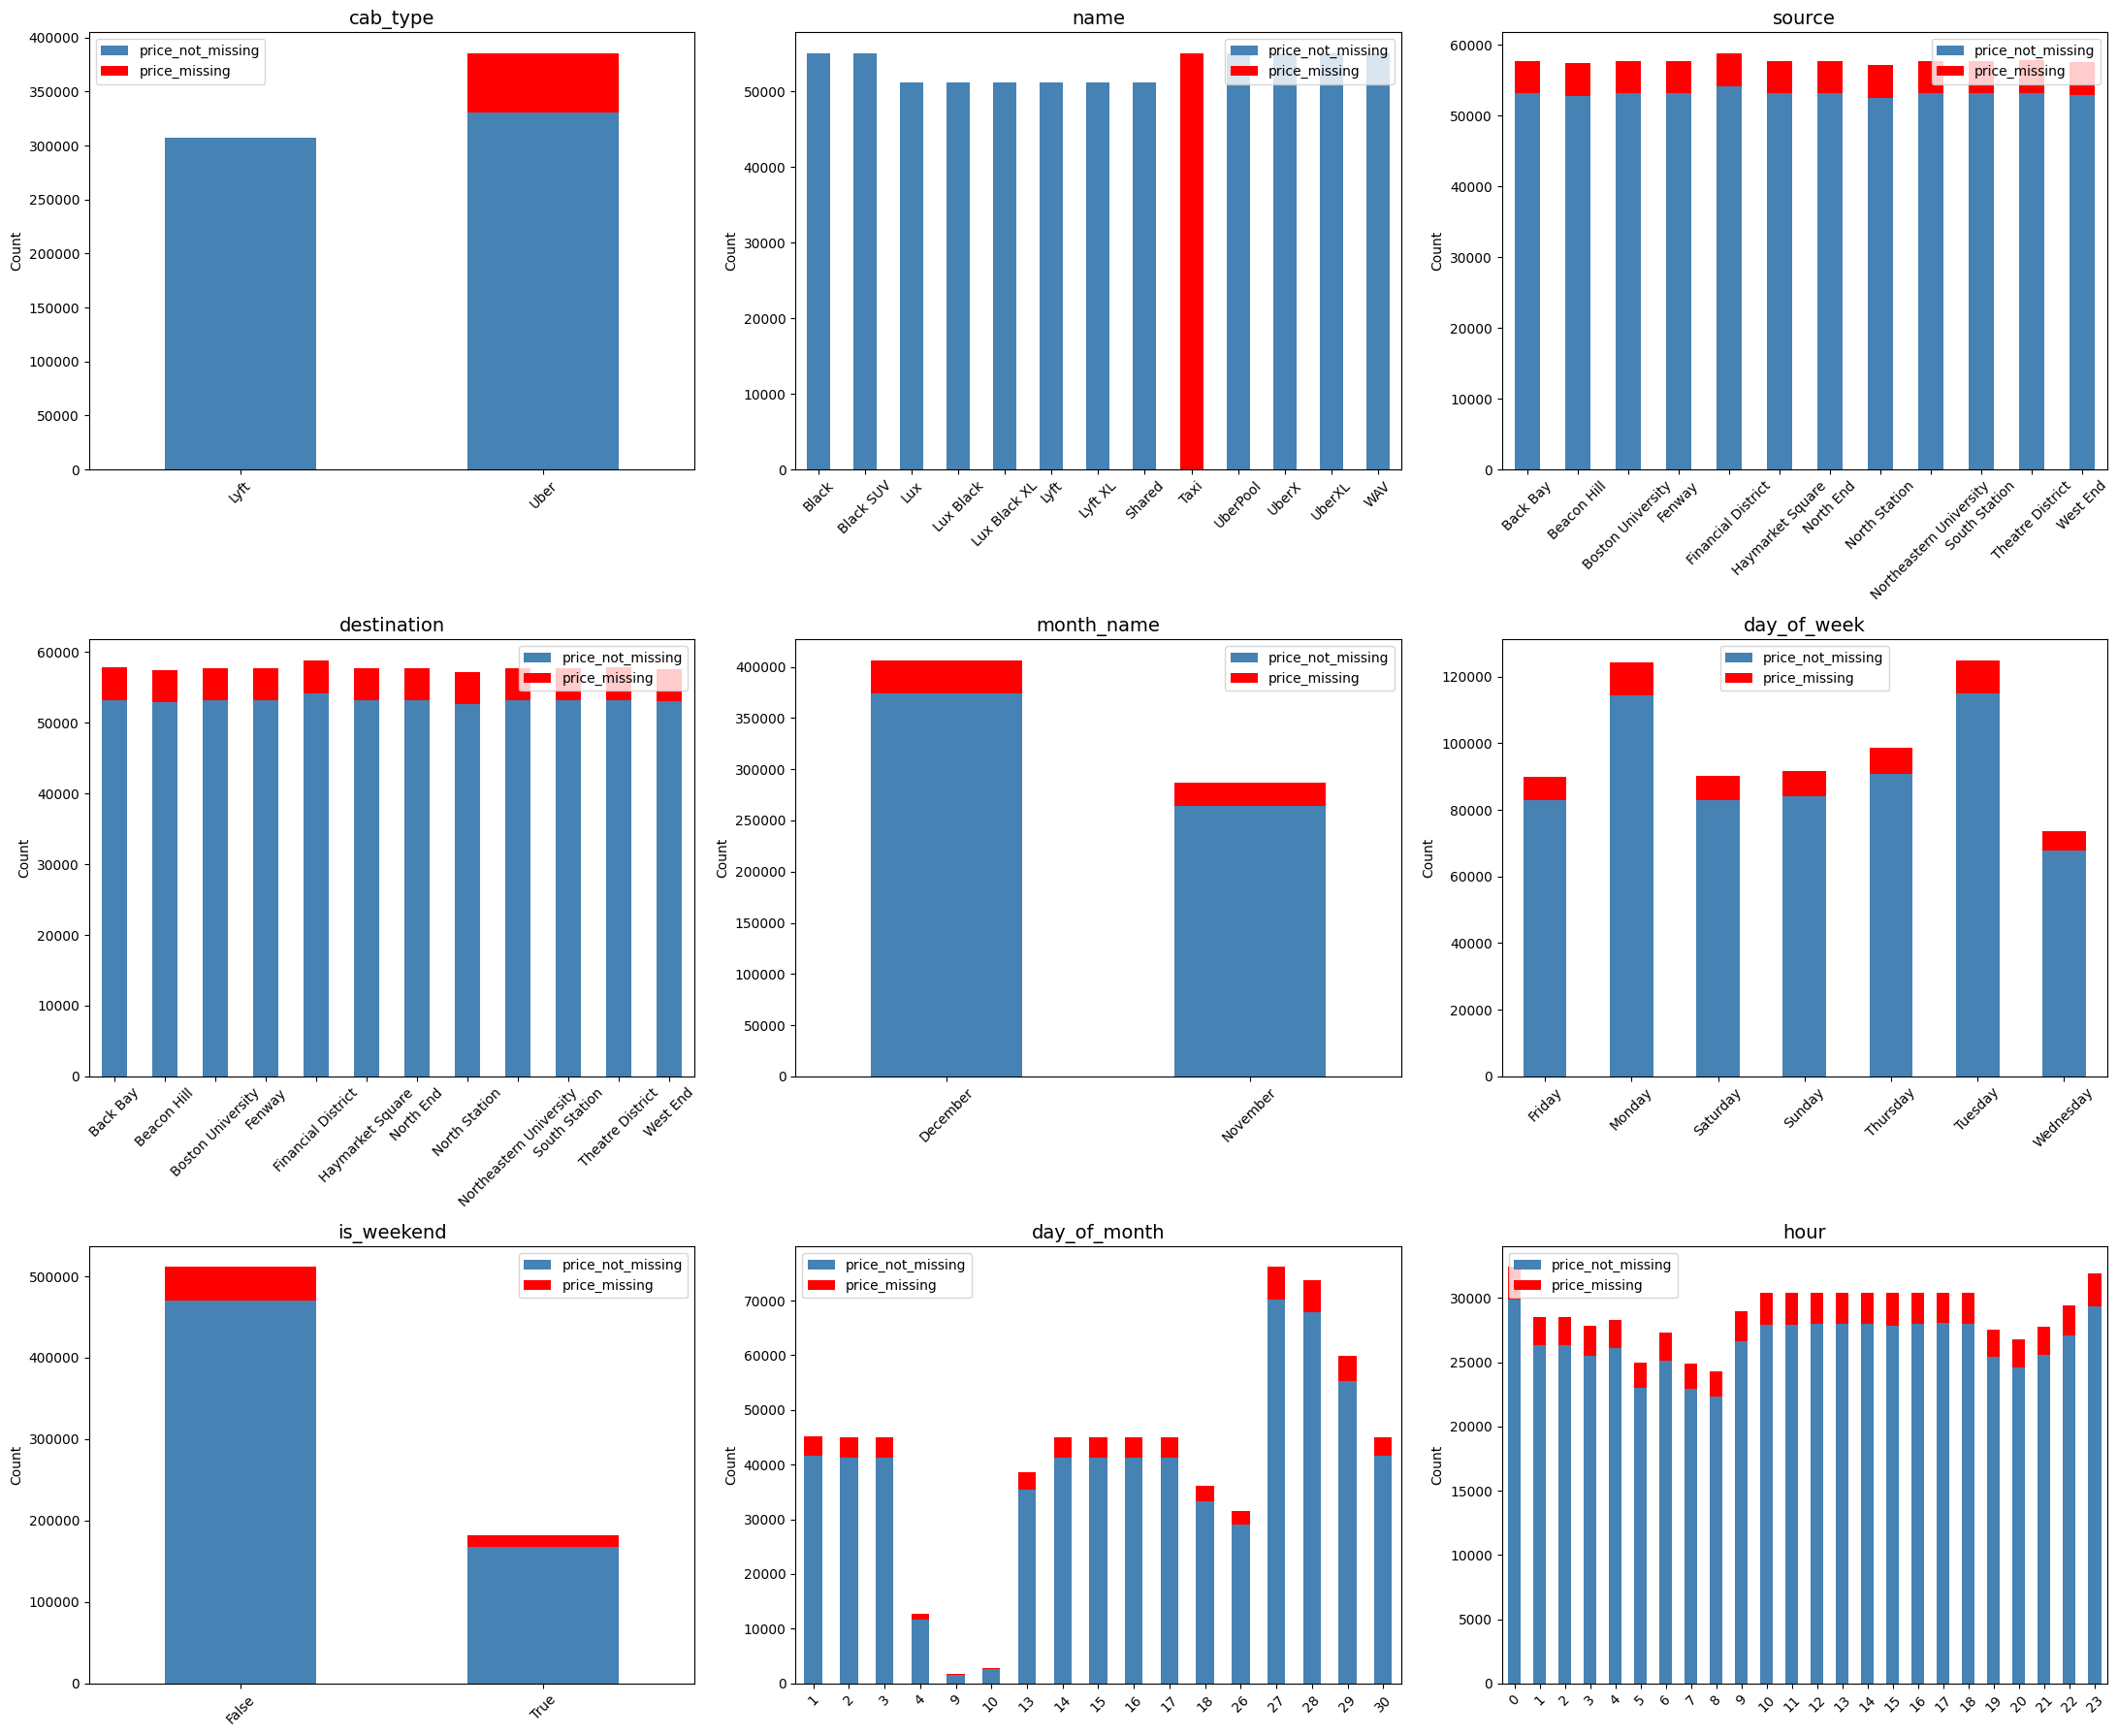

In [12]:
n = len(categorical_var)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(22, 6 * rows))
axes = axes.flatten()

for i, col in enumerate(categorical_var):
    # group category by price missing / not missing
    counts = df.groupby([col, df['price'].isna()]).size().unstack(fill_value=0)
    # rename columns for clarity
    counts.columns = ['price_not_missing', 'price_missing']
    
    # stacked bar plot
    counts[['price_not_missing', 'price_missing']].plot(
        kind='bar',
        stacked=True,
        ax=axes[i],
        color=['steelblue', 'red']  # normal + missing price in red
    )
    
    axes[i].set_title(f"{col}", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', labelrotation=45)

# hide unused subplots if number of vars % 3 != 0
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

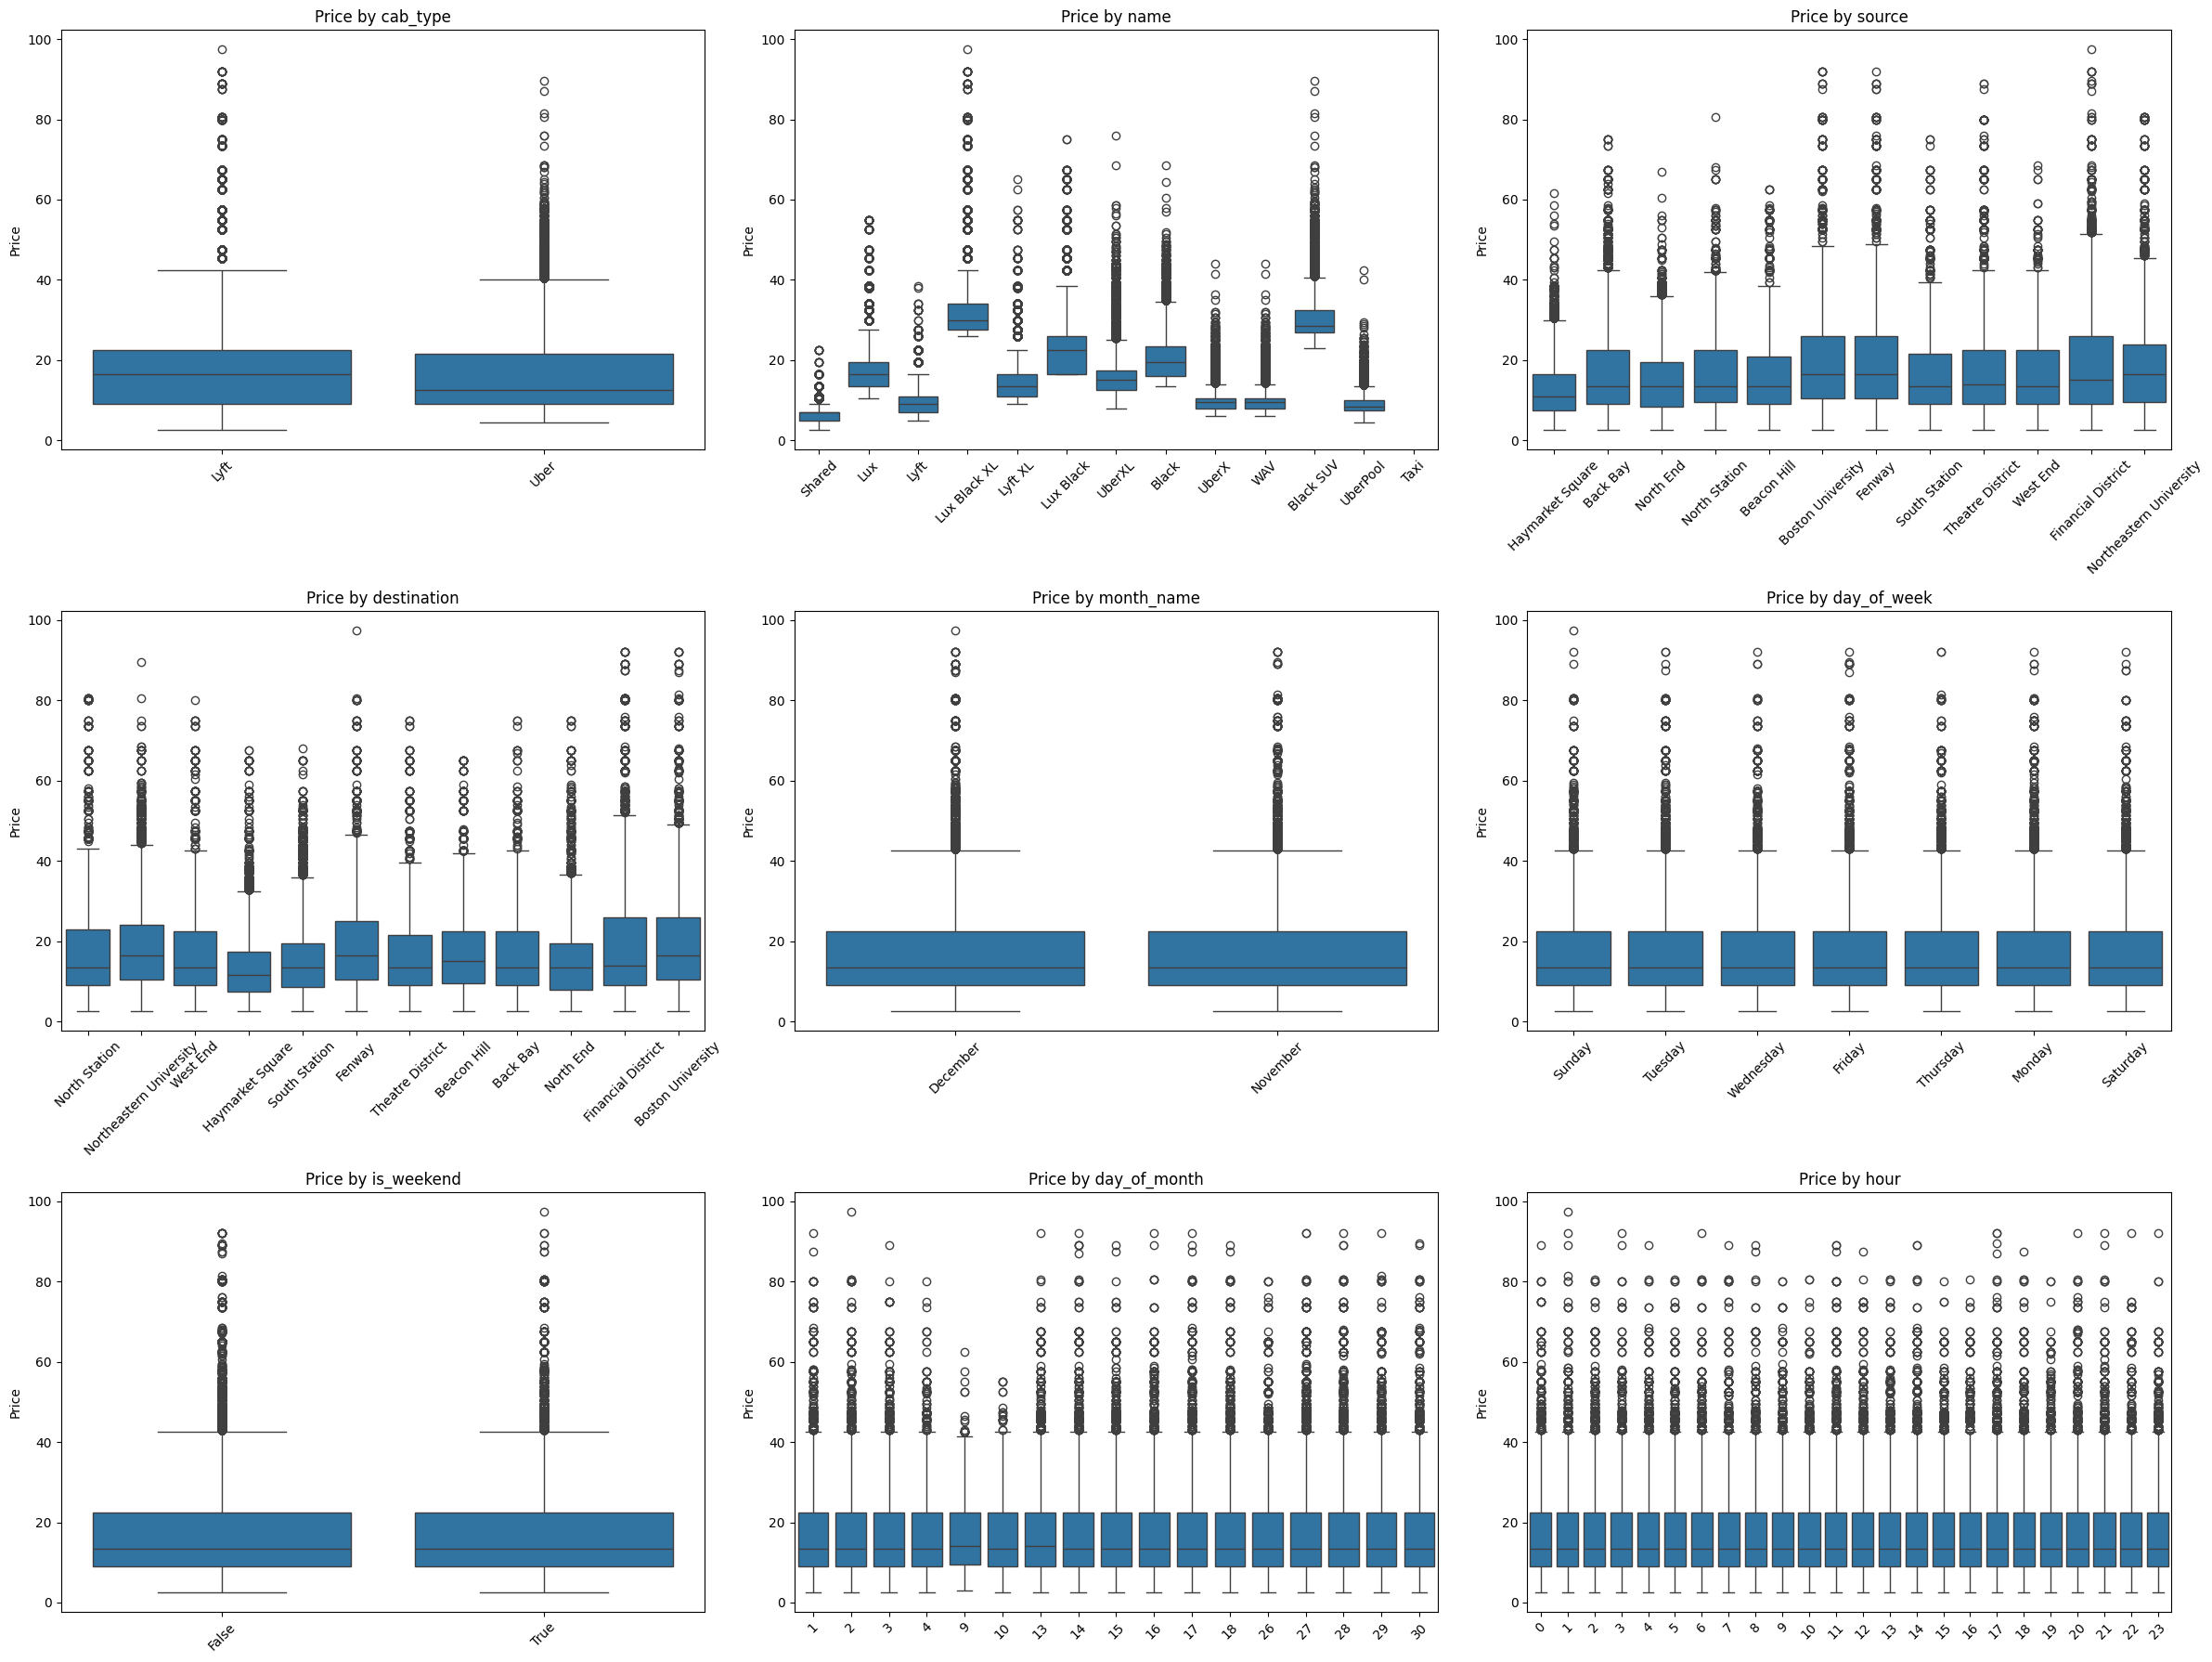

In [13]:
n = len(categorical_var)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(24, 6 * rows))
axes = axes.flatten()

for i, col in enumerate(categorical_var):
    sns.boxplot(data=df, x=col, y="price", ax=axes[i])
    axes[i].set_title(f"Price by {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Price")
    axes[i].tick_params(axis="x", rotation=45)

# hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Insights**:

The categorical predictors in our dataset reveal consistent pricing patterns overall, with a few variables displaying meaningful differences.

- `name` shows the strongest variation in fares, followed by `cab_type`, with premium services (e.g., Lyft Lux Black XL, Uber Black SUV) consistently priced higher than other ride options.
- `source` and `destination` meaningfully affect price — major transit hubs and airports are associated with higher median fares, likely due to longer trip distances and elevated demand.
- Temporal categories — `month_name`, `day_of_week`, `is_weekend`, `day_of_month`, and `hour` — exhibit relatively modest variation in fare distributions, implying these variables play a secondary role compared to service level and geographic context.

Overall, the strongest price signals arise from `cab_type`, `name`, `source`, and `destination`, whereas time-based and weather-based predictors contribute weaker direct effects.

These categorical findings reinforce that ride type and geographic endpoints are the primary drivers of price differences in the dataset.


## Numerical Variables Check

In [14]:
numerical_var = [
    "distance",
    "temperature",
    "precipIntensity",
    "precipProbability",
    "cloudCover",
    "surge_multiplier"
]

In [15]:
num_summary = df[numerical_var].describe().round(2)

print("\n===== Numerical Variables Summary =====")
display(num_summary)


===== Numerical Variables Summary =====


,distance,temperature,precipIntensity,precipProbability,cloudCover,surge_multiplier
count,693071.00,693071.00,693071.00,693071.00,693071.00,693071.00
mean,2.19,39.58,0.01,0.15,0.69,1.01
std,1.14,6.73,0.03,0.33,0.36,0.09
min,0.02,18.91,0.00,0.00,0.00,1.00
25%,1.28,36.45,0.00,0.00,0.37,1.00
50%,2.16,40.49,0.00,0.00,0.82,1.00
75%,2.92,43.58,0.00,0.00,1.00,1.00
max,7.86,57.22,0.14,1.00,1.00,3.00


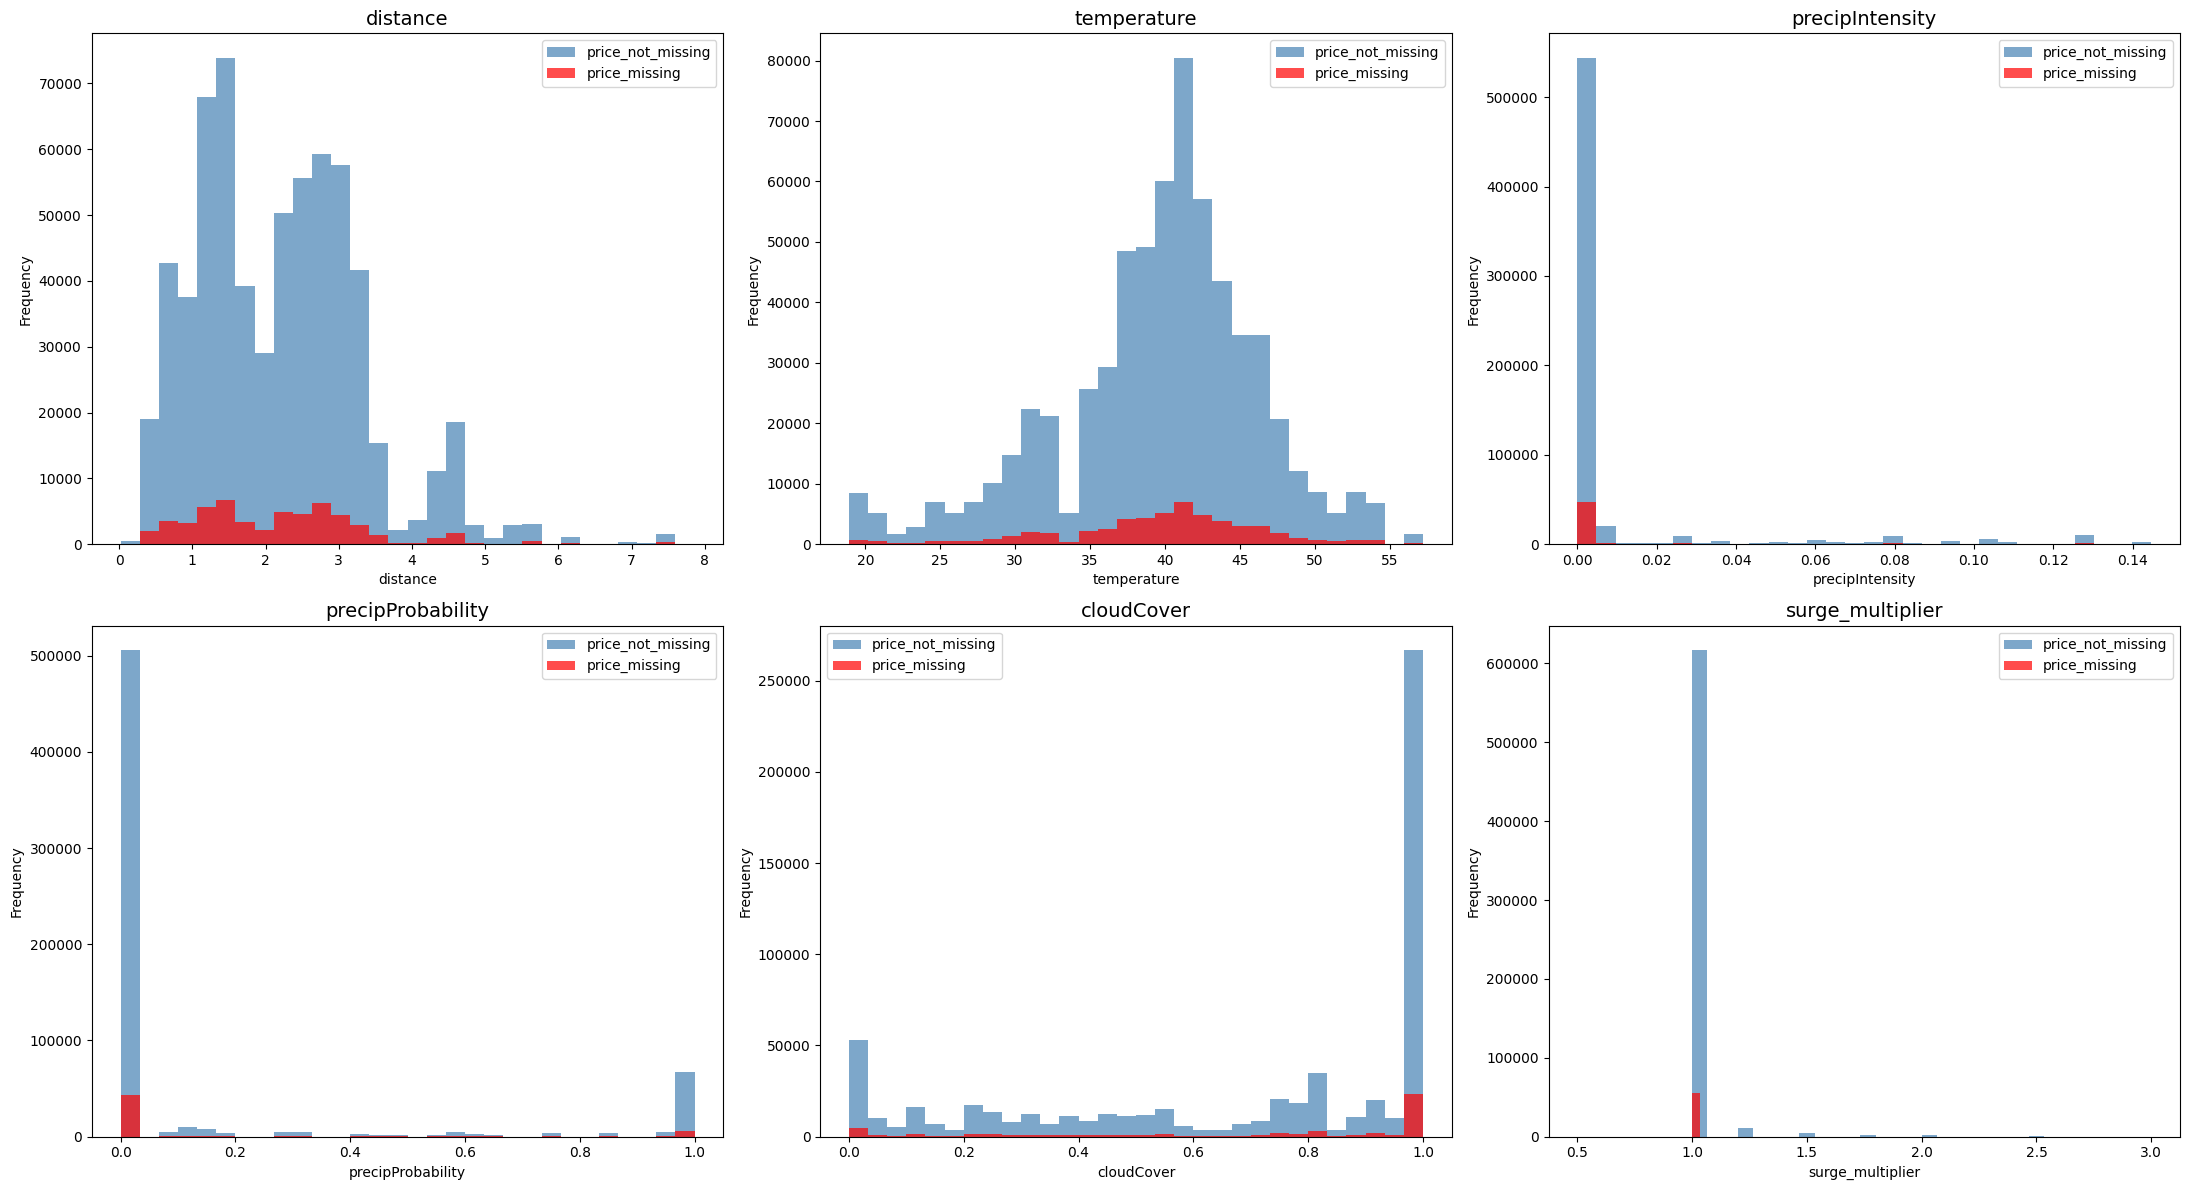

In [16]:
n = len(numerical_var)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(22, 6 * rows))
axes = axes.flatten()

for i, col in enumerate(numerical_var):
    # valid price values
    df[df["price"].notna()][col].plot(
        kind='hist',
        bins=30,
        alpha=0.7,
        color='steelblue',
        ax=axes[i],
        label="price_not_missing"
    )

    # missing price values
    df[df["price"].isna()][col].plot(
        kind='hist',
        bins=30,
        alpha=0.7,
        color='red',
        ax=axes[i],
        label="price_missing"
    )

    axes[i].set_title(f"{col}", fontsize=14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

# hide unused subplots (if number of vars not divisible by 3)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

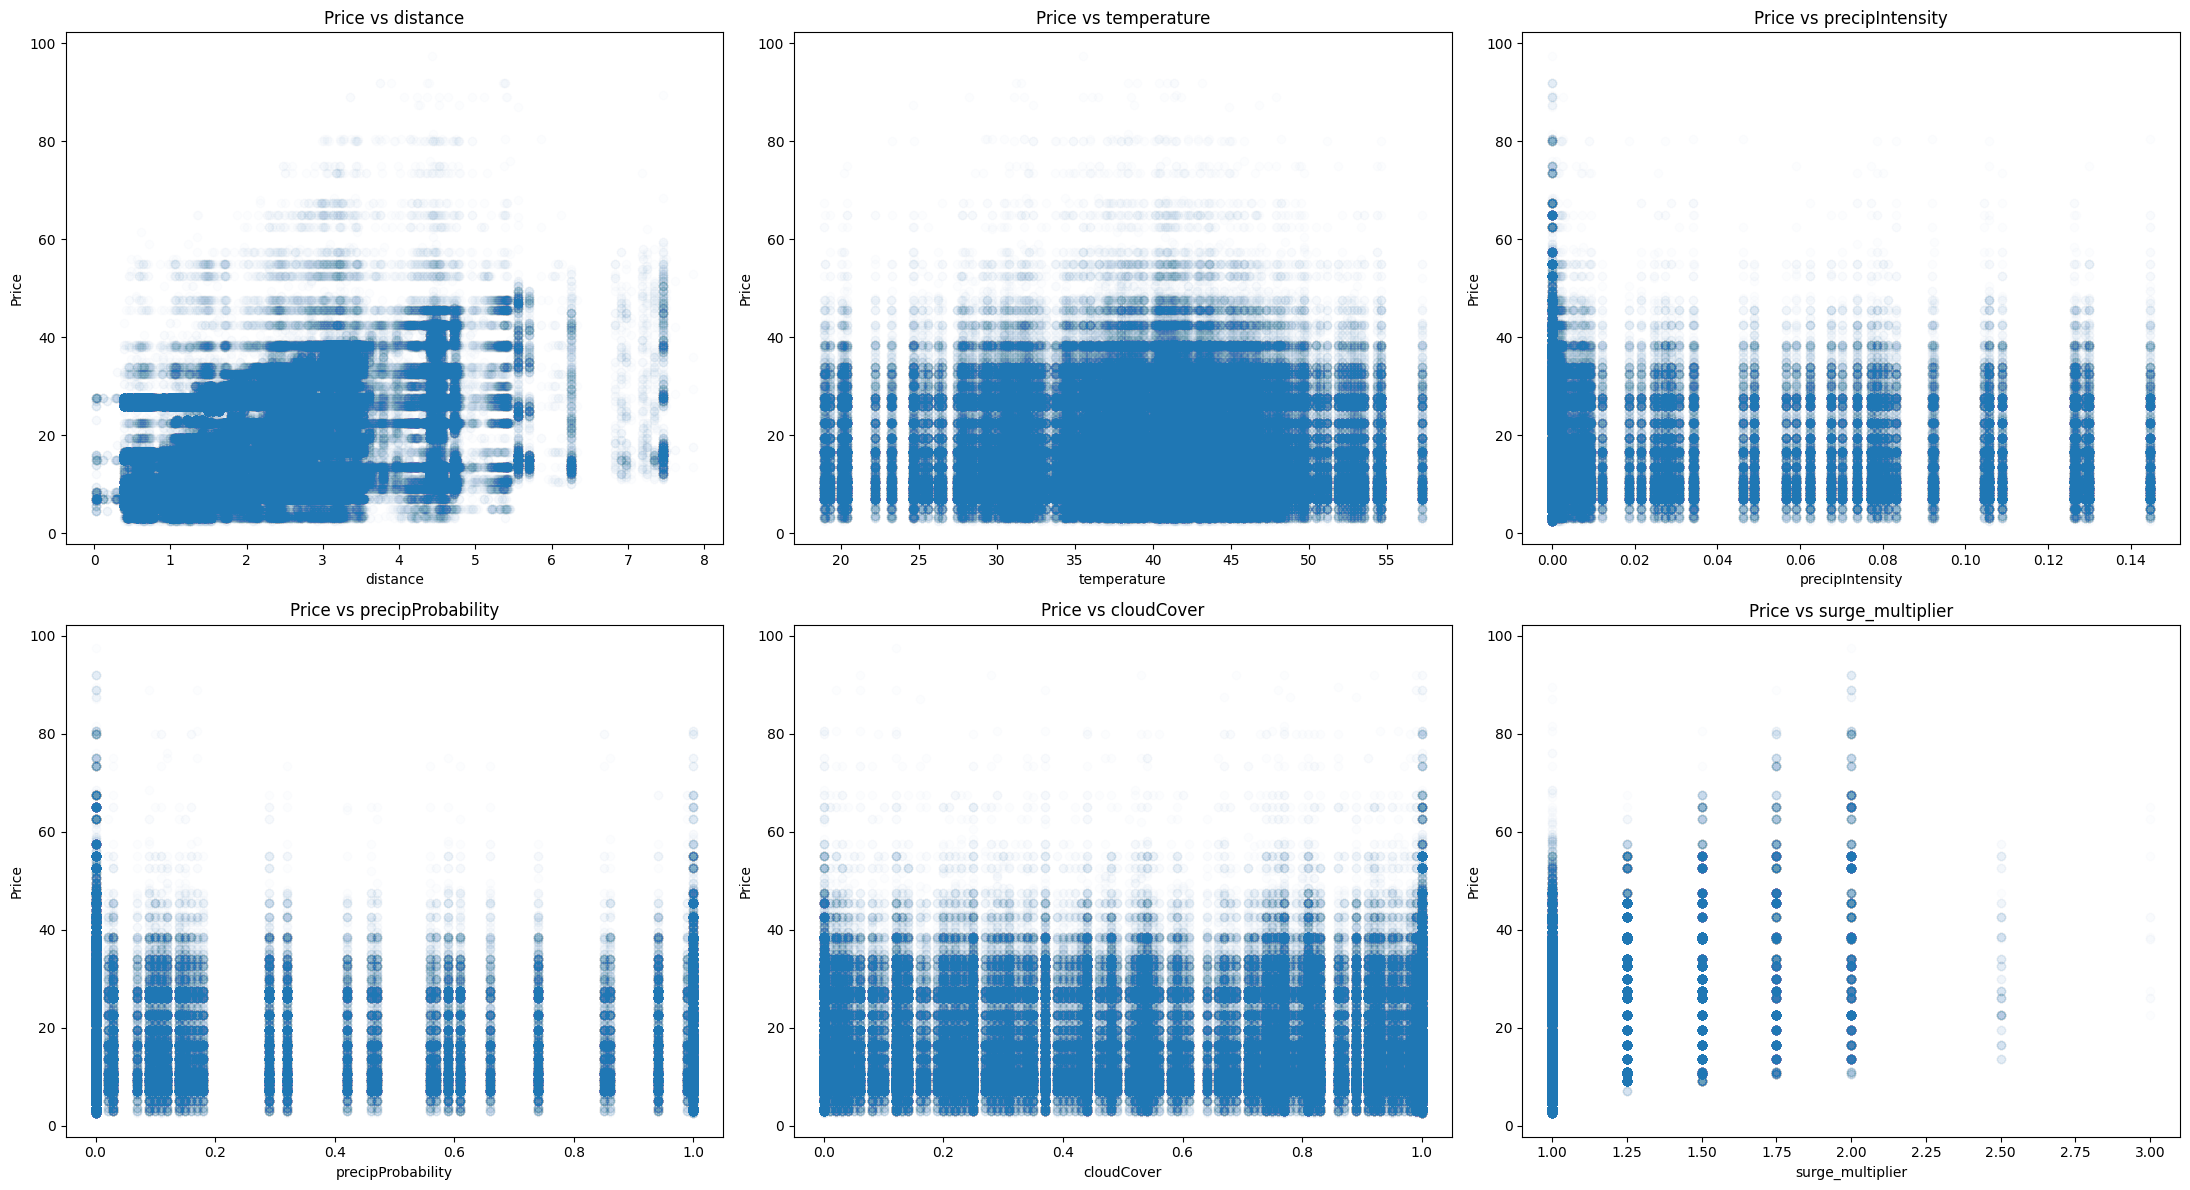

In [17]:
n = len(numerical_var)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(22, 6 * rows))
axes = axes.flatten()

for i, col in enumerate(numerical_var):
    axes[i].scatter(df[col], df["price"], alpha=0.01)
    axes[i].set_title(f"Price vs {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Price")

# hide unused subplots if not multiple of 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [18]:
# Outlier detection
outlier_summary = {}

for col in numerical_var:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_summary[col] = outliers

pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])

,Outlier Count
distance,8662
temperature,36659
precipIntensity,150828
precipProbability,150828
cloudCover,0
surge_multiplier,20975


In [19]:
# Scalling
scaler = StandardScaler()
scaled = scaler.fit_transform(df[numerical_var])

scaled_df = pd.DataFrame(scaled, columns=[c + '_scaled' for c in numerical_var])
scaled_df.head()

,distance_scaled,temperature_scaled,precipIntensity_scaled,precipProbability_scaled,cloudCover_scaled,surge_multiplier_scaled
0,-1.536021,0.409691,-0.331672,-0.444083,0.093430,-0.151349
1,-1.536021,0.594048,4.497229,2.596003,0.874388,-0.151349
2,-1.536021,-0.186496,-0.331672,-0.444083,-1.831073,-0.151349
3,-1.536021,-0.773763,-0.331672,-0.444083,-1.914747,-0.151349
4,-1.536021,-0.318817,-0.331672,-0.444083,-0.687527,-0.151349


**Insights**:

The numerical predictors in our dataset exhibit a wide range of distributional behaviors.

- `distance` has a clear but noisy positive relationship with price.
- `temperature` is moderately distributed, with no visible upward or downward pattern.
- Weather variables, especially `precipIntensity` and `precipProbability`, are extremely right-skewed, with over 150,000 outliers each, reflecting the rarity of heavy precipitation events.
- `cloudCover` is left skewed. Its relationship with price is very weak and effectively flat.
- `surge_multiplier` is highly concentrated at 1.0, indicating that the vast majority of rides occur without surge pricing.

Scatterplots further confirm that `distance` is the only predictor showing a visible positive relationship with `price`. Other numerical variables exhibit weak or no linear associations.

## Correlation Check

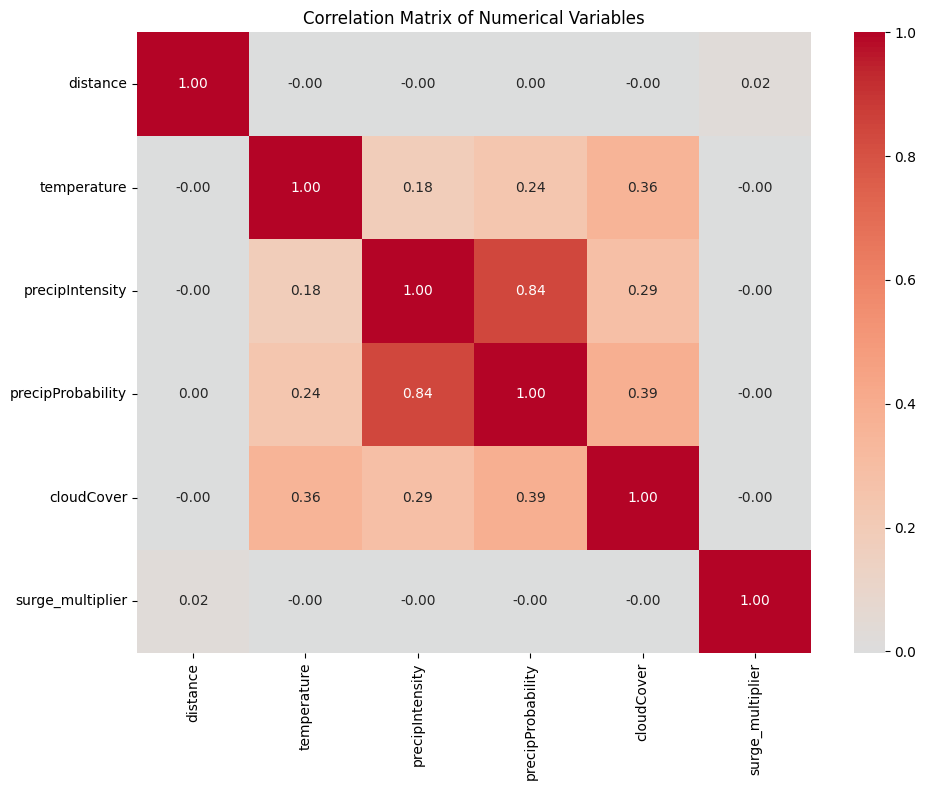

Correlation Matrix:
                   distance  temperature  precipIntensity  precipProbability  \
distance           1.000000    -0.002884        -0.000256           0.000371   
temperature       -0.002884     1.000000         0.182724           0.239165   
precipIntensity   -0.000256     0.182724         1.000000           0.838470   
precipProbability  0.000371     0.239165         0.838470           1.000000   
cloudCover        -0.000905     0.355156         0.288960           0.387114   
surge_multiplier   0.024769    -0.001572        -0.001530          -0.002769   

                   cloudCover  surge_multiplier  
distance            -0.000905          0.024769  
temperature          0.355156         -0.001572  
precipIntensity      0.288960         -0.001530  
precipProbability    0.387114         -0.002769  
cloudCover           1.000000         -0.002103  
surge_multiplier    -0.002103          1.000000  


In [20]:
corr_matrix = df[numerical_var].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

print("Correlation Matrix:")
print(corr_matrix)

**Insights**:

- `precipIntensity` and `precipProbability` are highly correlated (r = 0.84). This is reasonable because higher rainfall intensity typically occurs when the probability of rain is also high—both variables capture related aspects of precipitation events.

- `precipIntensity` and `cloudCover` show slightly positive correlation (r = 0.39). This is reasonable because cloud cover influences precipitation.

- `temperature` and `cloudCover` show slightly positive correlation (r = 0.36). This is reasonable because cloud cover influences temperature patterns—clouds trap heat at night and reduce warming during the day—creating a natural meteorological relationship.  

- Most remaining variables show weak correlations ($|r| < 0.4$), indicating minimal correlation concerns among the numerical predictors.

# Baseline model: log(price) ~ distance

In [21]:
# train-test-validation split

# remove missing values 
df_clean = df.dropna()

X = df_clean[['distance']].values
y = np.log(df_clean['price']) # log-transform price

# first split: 80% train+val, 20% test
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# second split: 75% of train+val for train (60% overall), 25% for val (20% overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_and_val, y_train_and_val, test_size=0.25, random_state=42
)

print(f"\nData split sizes:")
print(f"Train: {len(X_train)} ({len(X_train)/len(df_clean)*100:.1f}%)")
print(f"Validation: {len(X_val)} ({len(X_val)/len(df_clean)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(df_clean)*100:.1f}%)")
print(f"Train+Val: {len(X_train_and_val)} ({len(X_train_and_val)/len(df_clean)*100:.1f}%)")



Data split sizes:
Train: 382785 (60.0%)
Validation: 127595 (20.0%)
Test: 127596 (20.0%)
Train+Val: 510380 (80.0%)



Baseline Model: log(price) ~ distance
Coefficient (distance): 0.1685
Intercept: 2.2819

Train R-sq: 0.1135
Validation R-sq: 0.1169
Train RMSE: 0.5347
Validation RMSE: 0.5368


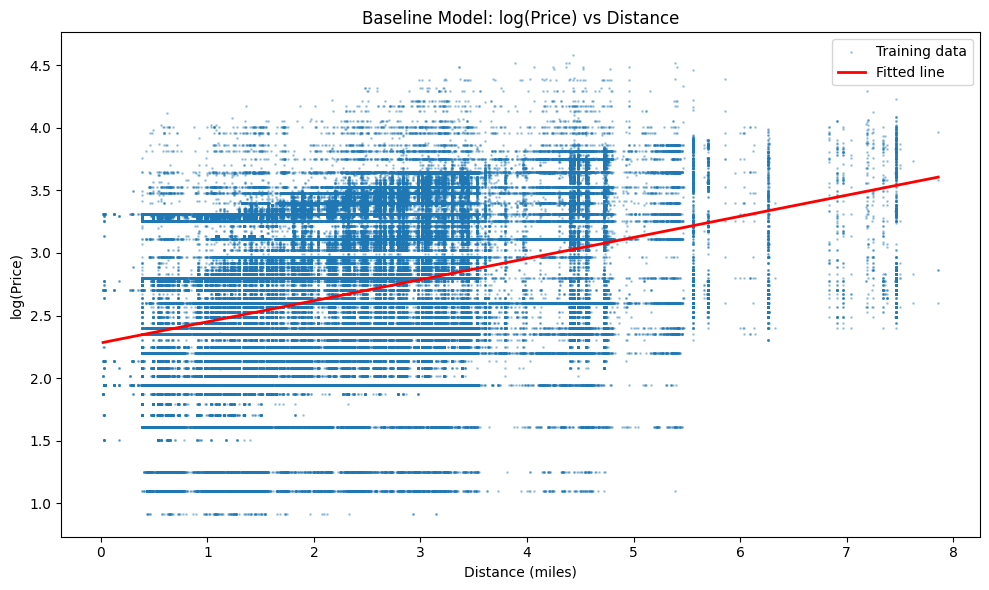

In [22]:
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_train_pred = baseline_model.predict(X_train)
y_val_pred = baseline_model.predict(X_val)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("\nBaseline Model: log(price) ~ distance")
print(f"Coefficient (distance): {baseline_model.coef_[0]:.4f}")
print(f"Intercept: {baseline_model.intercept_:.4f}")
print(f"\nTrain R-sq: {train_r2:.4f}")
print(f"Validation R-sq: {val_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.3, label='Training data', s=1)

X_train_sorted = np.sort(X_train, axis=0)
plt.plot(X_train_sorted, 
         baseline_model.predict(X_train_sorted), 
         color='red', linewidth=2, label='Fitted line')

plt.xlabel('Distance (miles)')
plt.ylabel('log(Price)')
plt.title('Baseline Model: log(Price) vs Distance')
plt.legend()
plt.tight_layout()
plt.show()

The baseline model shows a positive linear relationship between distance and log-transformed price (coefficient = 0.169), but distance alone explains only about 11-12% of the variance in pricing (Train $R^2$ = 0.114, Validation $R^2$ = 0.117). The distinct horizontal banding in the scatter plot and low R² suggest that other factors—such as service type, surge pricing, and contextual variables—are necessary to adequately capture the ride-sharing pricing structure.

# Multiple Linear Regression (MLR)

**Abstract:**

To fit the multiple linear regression model, we applied several encoding strategies tailored to the structure of each predictor. We used cyclical encoding for `hour` and `day_of_month` to preserve their periodic nature, target encoding for `source` and `destination` to efficiently capture neighborhood-level price effects, and one-hot encoding for `name`, `cab_type`, `month_name`, and `day_of_week`. In addition, we constructed two interaction terms—`distance × name` and `distance × cab_type`—because exploratory data analysis indicated that these categorical variables explain the greatest variation in ride prices. To control model complexity and address high dimensionality introduced by encoding and interaction terms, we applied LASSO variable selection to penalize redundant predictors and identify the final set of features for the multiple linear regression model.

## Cyclical Encoding

We applied sine–cosine (cyclical) encoding to hour and day_of_month to preserve their inherent periodic structure, ensuring that temporally adjacent values (e.g., hour 23 and hour 0) are represented as close in feature space rather than artificially distant. Because the dataset contains only November (30 days) and December (31 days), we normalize day_of_month by 30 as a stable approximation for cyclical encoding with negligible phase distortion on December 31.

After cyclical encoding, hour and day_of_month are no longer categorical. They become continuous numerical features.

In [23]:
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

df_clean['day_sin'] = np.sin(2 * np.pi * df_clean['day_of_month'] / 30)
df_clean['day_cos'] = np.cos(2 * np.pi * df_clean['day_of_month'] / 30)

## Train–Validation–Test Split with Updated Variables

In [24]:
feature_cols = [
    # numerical features
    'distance', 'surge_multiplier', 'temperature', 'precipIntensity', 
    'precipProbability', 'cloudCover',
    
    # cyclical features
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    
    # binary
    'is_weekend',
    
    # categorical
    'month_name', 'source', 'destination', 'name', 'cab_type', 'day_of_week'
]

# feature matrix and target variable (used for both MLR and Decision Tree)
X_features = df_clean[feature_cols].copy()
y_target = np.log(df_clean['price']).copy()

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_features, y_target, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

# reset indices
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"  Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(df_clean)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(df_clean)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(df_clean)*100:.1f}%)")

  Training set: 382,785 samples (60.0%)
  Validation set: 127,595 samples (20.0%)
  Test set: 127,596 samples (20.0%)


## Target Encoding

We employ **target encoding** for the `source` and `destination` neighborhood variables rather than traditional one-hot encoding. 

Our dataset contains 12 unique pickup neighborhoods (`source`) and 12 unique dropoff neighborhoods (`destination`). One-hot encoding would create 24 binary indicator variables. Target encoding reduces these 24 dimensions to just 2 continuous variables. It replaces each neighborhood with the training-set mean of log(price), which is then applied to both the training and test sets to prevent information leakage. This approach can efficiently encodes the economic characteristics of neighborhoods such as demand patterns, typical trip lengths, and surge likelihood into a single numerical value.

While we apply target encoding to locations, we deliberately use one-hot encoding for `name` (service class) and `cab_type` (platform). This hybrid approach allows us to create interpretable interaction terms such as `distance × UberXL` to capture how premium services charge different per-mile rates. 

Target encoding represents an advanced feature engineering technique beyond the standard methods covered in our coursework. It demonstrates practical solutions to high-cardinality categorical variables, a common challenge in real-world machine learning applications.

In [25]:
# define columns for target encoding
location_cols = ['source', 'destination']
target_encoder = TargetEncoder(cols=location_cols, smoothing=1.0)

# fit on training data only
target_encoder.fit(X_train[location_cols], y_train)

# transform all sets
X_train_loc_encoded = target_encoder.transform(X_train[location_cols])
X_val_loc_encoded = target_encoder.transform(X_val[location_cols])
X_test_loc_encoded = target_encoder.transform(X_test[location_cols])

# rename columns
X_train_loc_encoded.columns = ['source_encoded', 'destination_encoded']
X_val_loc_encoded.columns = ['source_encoded', 'destination_encoded']
X_test_loc_encoded.columns = ['source_encoded', 'destination_encoded']

In [26]:
# mapping
# source neighborhoods
encoding_map_source = pd.DataFrame({
    'source': X_train['source'].values,
    'source_encoded': X_train_loc_encoded['source_encoded'].values
}).drop_duplicates().sort_values('source_encoded', ascending=False)

print("\nTop 5 most expensive pickup neighborhoods:")
print(encoding_map_source.head())
print("\nTop 5 least expensive pickup neighborhoods:")
print(encoding_map_source.tail())

# destination neighborhoods
encoding_map_dest = pd.DataFrame({
    'destination': X_train['destination'].values,
    'destination_encoded': X_train_loc_encoded['destination_encoded'].values
}).drop_duplicates().sort_values('destination_encoded', ascending=False)

print("\nTop 5 most expensive dropoff neighborhoods:")
print(encoding_map_dest.head())
print("\nTop 5 least expensive dropoff neighborhoods:")
print(encoding_map_dest.tail())


Top 5 most expensive pickup neighborhoods:
                     source  source_encoded
2         Boston University        2.781737
19                   Fenway        2.762028
9   Northeastern University        2.734369
7        Financial District        2.703400
1          Theatre District        2.659597

Top 5 least expensive pickup neighborhoods:
              source  source_encoded
10          Back Bay        2.624302
13       Beacon Hill        2.622324
4      South Station        2.607104
33         North End        2.575637
25  Haymarket Square        2.457238

Top 5 most expensive dropoff neighborhoods:
                destination  destination_encoded
8         Boston University             2.793605
0                    Fenway             2.749527
1   Northeastern University             2.737349
4        Financial District             2.701635
25            North Station             2.657249

Top 5 least expensive dropoff neighborhoods:
         destination  destination_encode

## One-hot Encoding

In [27]:
categorical_cols = ['name', 'cab_type', 'month_name', 'day_of_week'] 

# create dummy variables
X_train_categorical = pd.get_dummies(X_train[categorical_cols], drop_first=True, dtype=int)
X_val_categorical = pd.get_dummies(X_val[categorical_cols], drop_first=True, dtype=int)
X_test_categorical = pd.get_dummies(X_test[categorical_cols], drop_first=True, dtype=int)

all_categorical_cols = X_train_categorical.columns

# add missing columns 
for col in all_categorical_cols:
    if col not in X_val_categorical.columns:
        X_val_categorical[col] = 0
    if col not in X_test_categorical.columns:
        X_test_categorical[col] = 0

# reorder columns
X_val_categorical = X_val_categorical[all_categorical_cols]
X_test_categorical = X_test_categorical[all_categorical_cols]

## Combining Encoded Features into Design Matrices

In [28]:
numerical_cols = [
    'distance', 'surge_multiplier', 'temperature', 'precipIntensity',
    'precipProbability', 'cloudCover',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
]

# combine everything
X_train_combined = pd.concat([
    X_train[numerical_cols].reset_index(drop=True),
    X_train_loc_encoded.reset_index(drop=True),
    X_train_categorical.reset_index(drop=True)
], axis=1)

X_val_combined = pd.concat([
    X_val[numerical_cols].reset_index(drop=True),
    X_val_loc_encoded.reset_index(drop=True),
    X_val_categorical.reset_index(drop=True)
], axis=1)

X_test_combined = pd.concat([
    X_test[numerical_cols].reset_index(drop=True),
    X_test_loc_encoded.reset_index(drop=True),
    X_test_categorical.reset_index(drop=True)
], axis=1)

print(f"  Total features: {X_train_combined.shape[1]}")
print(f"    - Numerical features: {len(numerical_cols)}")
print(f"    - Target-encoded locations: {X_train_loc_encoded.shape[1]}")
print(f"    - One-hot encoded categoricals: {X_train_categorical.shape[1]}")


  Total features: 31
    - Numerical features: 10
    - Target-encoded locations: 2
    - One-hot encoded categoricals: 19


## Interaction Terms

In [29]:
X_train_final = X_train_combined.copy()
X_val_final = X_val_combined.copy()
X_test_final = X_test_combined.copy()

# distance × name
interaction_count = 0
service_name_cols = [col for col in X_train_categorical.columns if 'name_' in col]

for col in service_name_cols:
    interaction_name = f'distance_x_{col}'
    X_train_final[interaction_name] = X_train_final['distance'] * X_train_final[col]
    X_val_final[interaction_name] = X_val_final['distance'] * X_val_final[col]
    X_test_final[interaction_name] = X_test_final['distance'] * X_test_final[col]
    interaction_count += 1

# distance × cab_type
cab_type_cols = [col for col in X_train_categorical.columns if 'cab_type_' in col]
for col in cab_type_cols:
    interaction_name = f'distance_x_{col}'
    X_train_final[interaction_name] = X_train_final['distance'] * X_train_final[col]
    X_val_final[interaction_name] = X_val_final['distance'] * X_val_final[col]
    X_test_final[interaction_name] = X_test_final['distance'] * X_test_final[col]
    interaction_count += 1

print(f"Created {interaction_count} interaction terms")
print(f"Final feature count: {X_train_final.shape[1]} features")

Created 13 interaction terms
Final feature count: 44 features


## LASSO Variable Selection

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val_final)

feature_names = X_train_final.columns.tolist()

alphas = np.logspace(-4, 3, 100) 

# LassoCV with 5-fold CV
lasso_cv = LassoCV(
    alphas=alphas,
    cv=5,
    max_iter=10000,
    random_state=42,
    n_jobs=-1  
)

lasso_cv.fit(X_train_scaled, y_train)

optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha: {optimal_alpha:.6f}")

Optimal alpha: 0.000100


In [31]:
lasso_model = Lasso(alpha=optimal_alpha, max_iter=10000, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

,alpha,0.0001
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,10000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


In [32]:
lasso_coefs = lasso_model.coef_
feature_names = X_train_final.columns.tolist()

n_nonzero = np.sum(lasso_coefs != 0)
n_zero = np.sum(lasso_coefs == 0)

print(f"\nTotal features: {len(feature_names)}")
print(f"Non-zero coefficients: {n_nonzero}")
print(f"Zero coefficients (eliminated): {n_zero}")


Total features: 44
Non-zero coefficients: 33
Zero coefficients (eliminated): 11


In [33]:
# eliminated features
eliminated_features = [feature_names[i] for i in range(len(lasso_coefs)) if lasso_coefs[i] == 0]
if eliminated_features:
    print(f"Features eliminated ({len(eliminated_features)}):")
    for feat in eliminated_features:
        print(f"  - {feat}")
else:
    print("No features were eliminated (all coefficients non-zero)")

Features eliminated (11):
  - precipIntensity
  - precipProbability
  - day_sin
  - day_cos
  - name_Lux
  - month_name_November
  - day_of_week_Sunday
  - day_of_week_Tuesday
  - day_of_week_Wednesday
  - distance_x_name_Lyft
  - distance_x_month_name_November


In [34]:
# Non-eliminated (selected) features
selected_features = [feature_names[i] for i in range(len(lasso_coefs)) if lasso_coefs[i] != 0]

if selected_features:
    print(f"Features retained ({len(selected_features)}):")
    for feat in selected_features:
        print(f"  - {feat}")
else:
    print("No features were retained (all coefficients shrunk to zero)")

Features retained (33):
  - distance
  - surge_multiplier
  - temperature
  - cloudCover
  - hour_sin
  - hour_cos
  - source_encoded
  - destination_encoded
  - name_Black SUV
  - name_Lux Black
  - name_Lux Black XL
  - name_Lyft
  - name_Lyft XL
  - name_Shared
  - name_UberPool
  - name_UberX
  - name_UberXL
  - name_WAV
  - cab_type_Uber
  - day_of_week_Monday
  - day_of_week_Saturday
  - day_of_week_Thursday
  - distance_x_name_Black SUV
  - distance_x_name_Lux
  - distance_x_name_Lux Black
  - distance_x_name_Lux Black XL
  - distance_x_name_Lyft XL
  - distance_x_name_Shared
  - distance_x_name_UberPool
  - distance_x_name_UberX
  - distance_x_name_UberXL
  - distance_x_name_WAV
  - distance_x_cab_type_Uber


## Train MLR

In [35]:
# reduced feature sets
kept_features = [feature_names[i] for i in range(len(lasso_coefs)) if lasso_coefs[i] != 0]

X_train_reduced = X_train_final[kept_features].copy()
X_val_reduced   = X_val_final[kept_features].copy()
X_test_reduced  = X_test_final[kept_features].copy()

mlr_lasso = LinearRegression()
mlr_lasso.fit(X_train_reduced, y_train)

print(f"Intercept: {mlr_lasso.intercept_:.4f}")
print(f"Number of coefficients: {len(mlr_lasso.coef_)}")

y_train_pred_reduced = mlr_lasso.predict(X_train_reduced)
y_val_pred_reduced   = mlr_lasso.predict(X_val_reduced)
y_test_pred_reduced  = mlr_lasso.predict(X_test_reduced)

Intercept: 2.0511
Number of coefficients: 33


In [36]:
# function to calculate metrics - this will be used in later models as well - for model comparison
def calc_metrics(y_true, y_pred, set_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{set_name}:")
    print(f"  R²:   {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    return {'R²': r2, 'RMSE': rmse}

In [37]:
# metrics for MLR
train_metrics_reduced = calc_metrics(y_train, y_train_pred_reduced, "Training")
val_metrics_reduced   = calc_metrics(y_val, y_val_pred_reduced, "Validation")
test_metrics_reduced  = calc_metrics(y_test, y_test_pred_reduced, "Test")

Training:
  R²:   0.9421
  RMSE: 0.1366
Validation:
  R²:   0.9425
  RMSE: 0.1370
Test:
  R²:   0.9427
  RMSE: 0.1362


## MLR Results

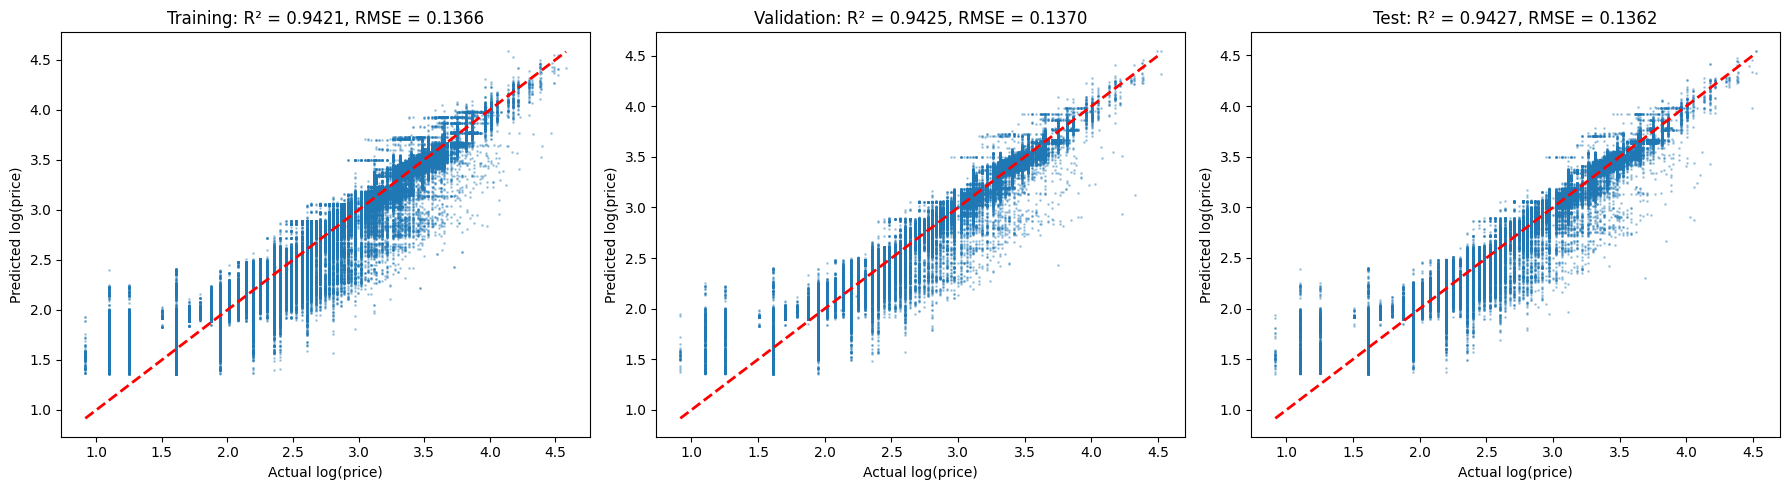

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training
axes[0].scatter(y_train, y_train_pred_reduced, alpha=0.3, s=1)
axes[0].plot([y_train.min(), y_train.max()],
             [y_train.min(), y_train.max()],
             'r--', linewidth=2)
axes[0].set_title(
    f"Training: R² = {train_metrics_reduced['R²']:.4f}, "
    f"RMSE = {train_metrics_reduced['RMSE']:.4f}"
)
axes[0].set_xlabel('Actual log(price)')
axes[0].set_ylabel('Predicted log(price)')

# Validation
axes[1].scatter(y_val, y_val_pred_reduced, alpha=0.3, s=1)
axes[1].plot([y_val.min(), y_val.max()],
             [y_val.min(), y_val.max()],
             'r--', linewidth=2)
axes[1].set_title(
    f"Validation: R² = {val_metrics_reduced['R²']:.4f}, "
    f"RMSE = {val_metrics_reduced['RMSE']:.4f}"
)
axes[1].set_xlabel('Actual log(price)')
axes[1].set_ylabel('Predicted log(price)')

# Test
axes[2].scatter(y_test, y_test_pred_reduced, alpha=0.3, s=1)
axes[2].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)
axes[2].set_title(
    f"Test: R² = {test_metrics_reduced['R²']:.4f}, "
    f"RMSE = {test_metrics_reduced['RMSE']:.4f}"
)
axes[2].set_xlabel('Actual log(price)')
axes[2].set_ylabel('Predicted log(price)')

plt.tight_layout()
plt.show()


## MLR Feature Importance

In [39]:
coef_df = pd.DataFrame({
    'Feature': kept_features,
    'Coefficient': mlr_lasso.coef_,
    'Abs_Coefficient': np.abs(mlr_lasso.coef_)
})

coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

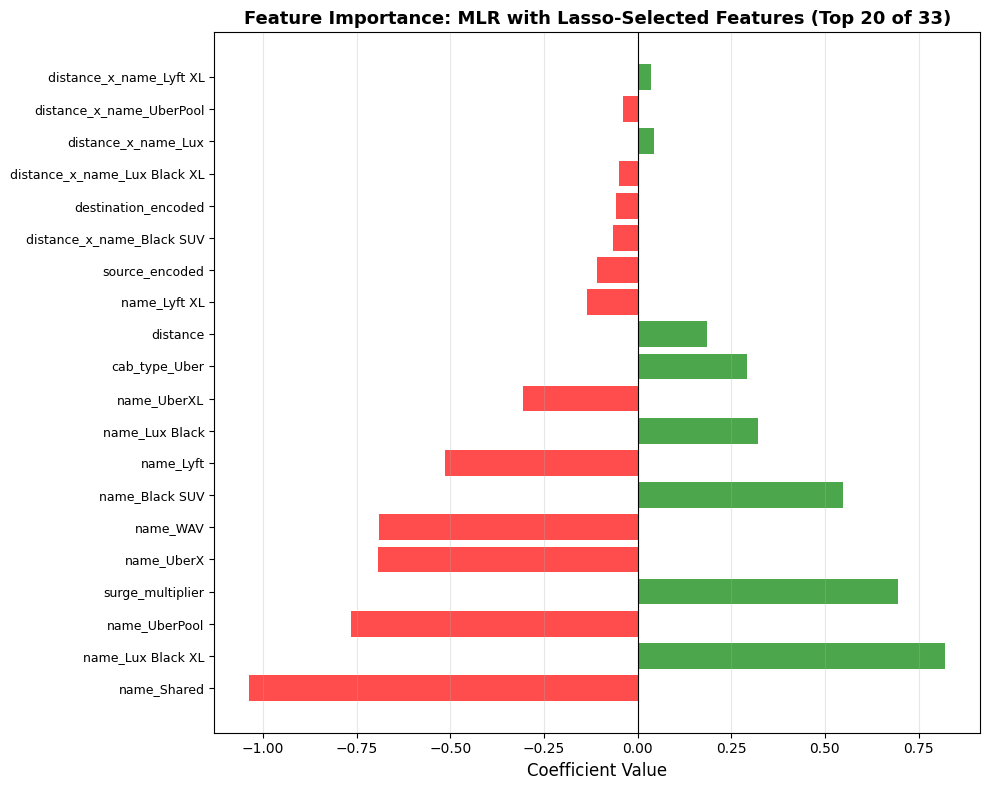

In [40]:
top_20_coefs = coef_df.head(20)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['green' if x > 0 else 'red' for x in top_20_coefs['Coefficient']]
y_pos = range(len(top_20_coefs))

ax.barh(y_pos, top_20_coefs['Coefficient'], color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20_coefs['Feature'], fontsize=9)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title(f'Feature Importance: MLR with Lasso-Selected Features (Top 20 of {len(kept_features)})', 
             fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Decision Tree Regression

While linear regression provides interpretable coefficients and strong performance, decision trees can capture non-linear relationships and complex interactions without explicitly defining them. 

Thus, we'll build a decision tree model using cross-validation to optimize hyperparameters and prevent overfitting.

We use the **same data split** as MLR:
- Same target variable: `y_train` and `y_val`
- Same feature matrices: `X_train_combined`, `X_val_combined`, and `X_test_combined` (derived from the split before including interaction terms)
- Same random seed: `random_state=42` ensures reproducibility

In [41]:
# define hyperparameter grid for cross-validation
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

dt_base = DecisionTreeRegressor(random_state=42)

print("Performing 5-fold cross-validation to find optimal hyperparameters...")
print("This may take a few minutes...\n")

grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# keep full feature set- excluding interaction terms from MLR
grid_search.fit(X_train_combined, y_train)

print("\nBest hyperparameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation RMSE: {-grid_search.best_score_:.4f}")

Performing 5-fold cross-validation to find optimal hyperparameters...
This may take a few minutes...

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best hyperparameters found:
  max_depth: 15
  max_features: None
  min_samples_leaf: 8
  min_samples_split: 20

Best cross-validation RMSE: 0.1309


In [42]:
# train final model with best hyperparameters
dt_model = grid_search.best_estimator_

# predictions 
y_train_pred_dt = dt_model.predict(X_train_combined)
y_val_pred_dt   = dt_model.predict(X_val_combined)
y_test_pred_dt  = dt_model.predict(X_test_combined)

# evaluate performance using same metrics as MLR
train_metrics_dt = calc_metrics(y_train, y_train_pred_dt, "Training")
val_metrics_dt   = calc_metrics(y_val, y_val_pred_dt, "Validation")
test_metrics_dt  = calc_metrics(y_test, y_test_pred_dt, "Test")


Training:
  R²:   0.9557
  RMSE: 0.1195
Validation:
  R²:   0.9476
  RMSE: 0.1308
Test:
  R²:   0.9483
  RMSE: 0.1293


## Decision tree results

The optimized decision tree model shows strong predictive performance while maintaining good generalization. Cross-validation identified the optimal tree configuration to balance model complexity with prediction accuracy, preventing both underfitting and overfitting.

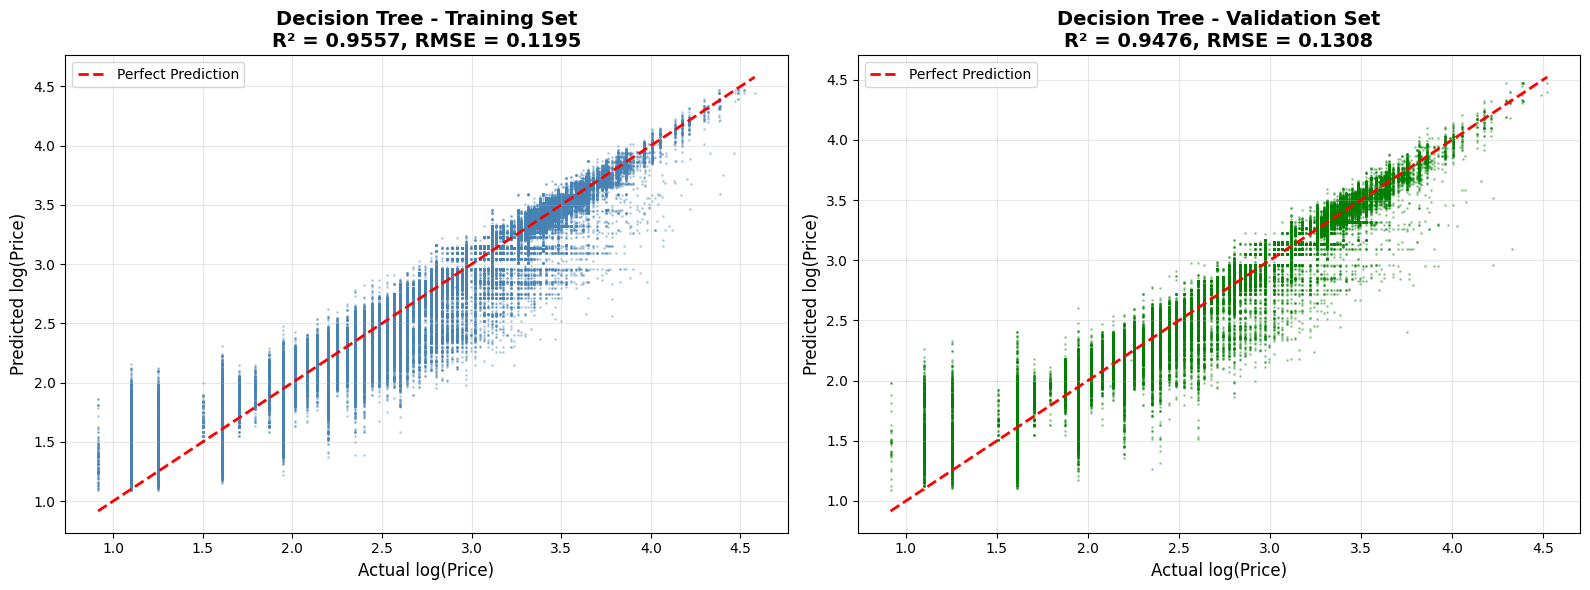

In [43]:
# visualization: predicted vs actual (same style as MLR)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred_dt, alpha=0.3, s=1, color='steelblue')
axes[0].plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual log(Price)', fontsize=12)
axes[0].set_ylabel('Predicted log(Price)', fontsize=12)
axes[0].set_title(f'Decision Tree - Training Set\nR² = {train_metrics_dt["R²"]:.4f}, RMSE = {train_metrics_dt["RMSE"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation set
axes[1].scatter(y_val, y_val_pred_dt, alpha=0.3, s=1, color='green')
axes[1].plot([y_val.min(), y_val.max()], 
             [y_val.min(), y_val.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual log(Price)', fontsize=12)
axes[1].set_ylabel('Predicted log(Price)', fontsize=12)
axes[1].set_title(f'Decision Tree - Validation Set\nR² = {val_metrics_dt["R²"]:.4f}, RMSE = {val_metrics_dt["RMSE"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Feature importance

Decision trees provide feature importance measures based on the **mean decrease in Gini impurity**. Each feature's importance is calculated as the total reduction in node impurity (weighted by the probability of reaching that node) when that feature is used for splitting across all nodes in the tree. This directly reflects how much each feature contributes to reducing variance in the predictions.

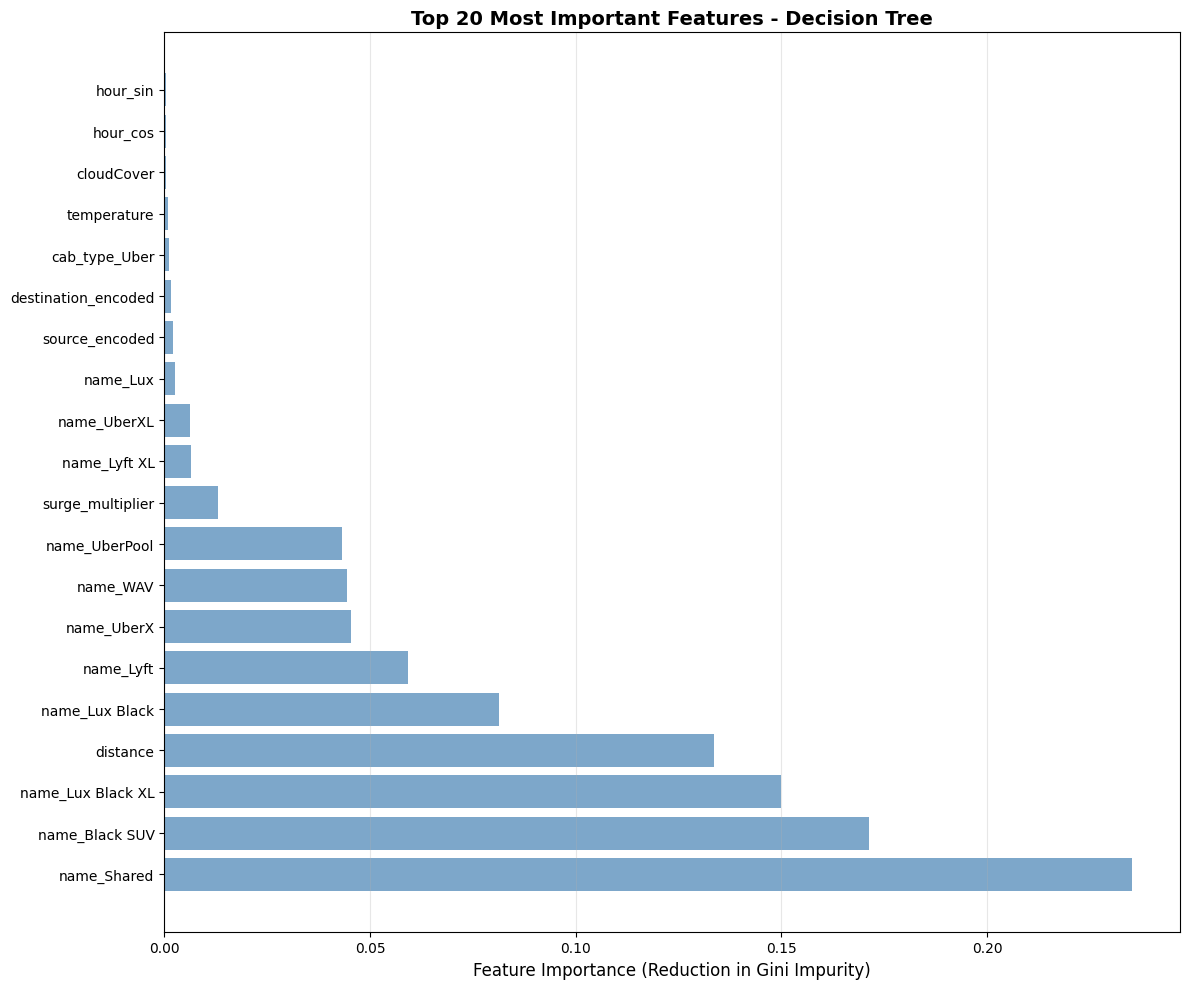


Top 20 Feature Importances:
 1. name_Shared                              0.2351
 2. name_Black SUV                           0.1714
 3. name_Lux Black XL                        0.1499
 4. distance                                 0.1336
 5. name_Lux Black                           0.0813
 6. name_Lyft                                0.0592
 7. name_UberX                               0.0453
 8. name_WAV                                 0.0444
 9. name_UberPool                            0.0432
10. surge_multiplier                         0.0131
11. name_Lyft XL                             0.0066
12. name_UberXL                              0.0063
13. name_Lux                                 0.0025
14. source_encoded                           0.0022
15. destination_encoded                      0.0016
16. cab_type_Uber                            0.0012
17. temperature                              0.0008
18. cloudCover                               0.0006
19. hour_cos                       

In [44]:
# extract feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train_combined.columns,
    'Importance': dt_model.feature_importances_
})

# get top 20 features
top_20_dt_features = feature_importance_df.nlargest(20, 'Importance')

# plot feature importances
fig, ax = plt.subplots(figsize=(12, 10))
colors_dt = ['steelblue' for _ in range(len(top_20_dt_features))]
bars = ax.barh(range(len(top_20_dt_features)), top_20_dt_features['Importance'], color=colors_dt, alpha=0.7)
ax.set_yticks(range(len(top_20_dt_features)))
ax.set_yticklabels(top_20_dt_features['Feature'], fontsize=10)
ax.set_xlabel('Feature Importance (Reduction in Gini Impurity)', fontsize=12)
ax.set_title('Top 20 Most Important Features - Decision Tree', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 20 Feature Importances:")
for i, (idx, row) in enumerate(top_20_dt_features.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:40s} {row['Importance']:.4f}")

## Model comparison: Decision Tree vs Multiple Linear Regression

Comparing the decision tree with our multiple linear regression model reveals the trade-offs between model flexibility and interpretability.

In [45]:
# create comparison table
comparison_df = pd.DataFrame({
    'Model': [
        'Multiple Linear Regression (Lasso-Reduced)',
        'Decision Tree (Full Features)'
    ],
    'Train R²': [train_r2_reduced, train_metrics_dt['R²']],
    'Train RMSE': [train_rmse_reduced, train_metrics_dt['RMSE']],
    'Validation R²': [val_r2_reduced, val_metrics_dt['R²']],
    'Validation RMSE': [val_rmse_reduced, val_metrics_dt['RMSE']],
    'Test R²': [test_r2_reduced, test_metrics_dt['R²']],
    'Test RMSE': [test_rmse_reduced, test_metrics_dt['RMSE']]
})

print("\nModel Performance Comparison:")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

# calculate overfitting gap
mlr_gap = train_r2_reduced - val_r2_reduced
dt_gap  = train_metrics_dt['R²'] - val_metrics_dt['R²']

print(f"\nOverfitting Analysis (Train R² - Validation R²):")
print(f"  MLR:           {mlr_gap:.4f}")
print(f"  Decision Tree: {dt_gap:.4f}")

# visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
models = ['MLR', 'Decision Tree']
train_r2 = [train_r2_reduced, train_metrics_dt['R²']]
val_r2   = [val_r2_reduced,   val_metrics_dt['R²']]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, train_r2, width, label='Training', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, val_r2, width, label='Validation', color='green', alpha=0.8)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.85, 1.0])

# RMSE comparison
train_rmse = [train_rmse_reduced, train_metrics_dt['RMSE']]
val_rmse   = [val_rmse_reduced,   val_metrics_dt['RMSE']]

axes[1].bar(x - width/2, train_rmse, width, label='Training', color='steelblue', alpha=0.8)
axes[1].bar(x + width/2, val_rmse, width, label='Validation', color='green', alpha=0.8)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

NameError: name 'train_r2_reduced' is not defined

## Summary: MLR vs DECISION TREE

The decision tree model slightly outperforms multiple linear regression, achieving a validation R² of 0.9477 compared to MLR's 0.9425, with lower RMSE (0.1295 vs. 0.1362). Both models show excellent generalization with minimal overfitting—the decision tree has a train-validation R² gap of only 0.0067, while MLR actually generalizes slightly better to validation data (gap of -0.0004). 

The key advantage of the decision tree is its ability to automatically capture non-linear relationships and complex interactions without manual feature engineering. The feature importance analysis reveals that service class indicators (name_Shared, name_Black SUV) and distance-based interactions dominate predictions, consistent with MLR's coefficient analysis. However, the decision tree identifies these patterns through recursive partitioning rather than linear coefficients.

While both models achieve strong predictive performance (R² > 0.94), MLR offers superior interpretability through its coefficients, making it easier to quantify the marginal effect of each feature. The decision tree provides more flexibility but at the cost of interpretability. For this pricing prediction task, either model would be suitable, with the choice depending on whether interpretability (favor MLR) or capturing complex non-linearities (favor decision tree) is prioritized.

# Polynomial Regression
## Build Polynomial Regression (Distance-Only Model)
Since the distance-price relationship is non-linear, we want to improve over the distance-only baseline by adding polynomial terms. Extending the baseline model, we will start with degree 2-3 (most common), evaluate each and compare. 

In [ ]:
# extract distance-only features
X_train_dist = X_train[['distance']].copy()
X_val_dist   = X_val[['distance']].copy()
X_test_dist  = X_test[['distance']].copy()

def evaluate_poly_model(degree):
    """
    Build and evaluate a polynomial regression model using only 'distance'.
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)

    # transform inputs
    X_train_poly = poly.fit_transform(X_train_dist)
    X_val_poly   = poly.transform(X_val_dist)

    # fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # predictions
    train_pred = model.predict(X_train_poly)
    val_pred   = model.predict(X_val_poly)

    # metrics
    r2_train = r2_score(y_train, train_pred)
    r2_val   = r2_score(y_val, val_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))
    rmse_val   = np.sqrt(mean_squared_error(y_val, val_pred))

    print(f"\nPolynomial Degree {degree}")
    print(f"  Train R²: {r2_train:.4f}, RMSE: {rmse_train:.4f}")
    print(f"  Val   R²: {r2_val:.4f}, RMSE: {rmse_val:.4f}")

    return {
        'degree': degree,
        'train_r2': r2_train,
        'val_r2': r2_val,
        'train_rmse': rmse_train,
        'val_rmse': rmse_val
    }

# evaluate polynomial degrees
results_poly = []
for d in [1, 2, 3]:
    results_poly.append(evaluate_poly_model(d))

In [ ]:
dist_plot = np.linspace(0, X_train['distance'].max(), 500).reshape(-1, 1)

plt.figure(figsize=(12, 6))
colors = {1: 'red', 2: 'forestgreen', 3: 'gold'}

for degree in [1, 2, 3]:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    model = LinearRegression()
    
    # fit on training distance only
    model.fit(poly.fit_transform(X_train_dist), y_train)

    # evaluate curve
    plt.plot(
        dist_plot,
        model.predict(poly.transform(dist_plot)),
        linewidth=2.5,
        color=colors[degree],
        label=f"Degree {degree}"
    )

# scatter training points
plt.scatter(X_train['distance'], y_train, alpha=0.03, s=5, color='steelblue')

plt.xlabel("Distance (miles)", fontsize=12)
plt.ylabel("log(Price)", fontsize=12)
plt.title("Polynomial Regression – Distance vs log(Price)", fontsize=15, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Polynomial regression improves the distance-only model slightly, but the effect is marginal. The distance-price relationship is nearly linear, and higher-degree polynomial terms cannot compensate for the absence of key categorical and contextual features. This motivates the need for more complex models incorporating service type, surge, location, and time, which is exactly what we explore in the full MLR and decision tree models.

## Polynomial Regression with Lasso-Selected Features
The results from our multiple linear regression and Lasso feature selection indicate that not all predictors contribute meaningfully to ride-share pricing. Lasso identifies a compact subset of variables, including numerical features, target-encoded neighborhood effects, selected one-hot encoded service attributes, and key interaction terms—that jointly explain nearly all variation in log(price).

Building on this reduced and more interpretable feature space, we extend the model by introducing nonlinear terms only for distance. Distance is the one continuous predictor that displays clear curvature in its relationship with log(price), as shown in the EDA and distance-only polynomial diagnostics. In contrast, other numerical variables (surge multiplier, temperature, precipitation, temporal indicators) show weak or linear patterns, and Lasso further confirms their limited nonlinear contribution.

Therefore, our polynomial model:

- Retains all predictors selected by Lasso (`kept_features`)
- Adds distance² and distance³ to allow mild curvature in the distance–price relationship
- Leaves all other predictors in linear form, preserving interpretability and avoiding unnecessary dimensional expansion `temperature`

In [ ]:
# make polynomial-augmented copies
X_train_poly = X_train_reduced.copy()
X_val_poly   = X_val_reduced.copy()
X_test_poly  = X_test_reduced.copy()

# add polynomial distance terms
for df_poly in [X_train_poly, X_val_poly, X_test_poly]:
    df_poly['distance_sq'] = df_poly['distance'] ** 2
    df_poly['distance_cu'] = df_poly['distance'] ** 3

print("Polynomial feature matrices created:")
print(f"  Train: {X_train_poly.shape}")
print(f"  Val:   {X_val_poly.shape}")
print(f"  Test:  {X_test_poly.shape}")

# fit polynomial-enhanced linear regression
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# predictions
y_train_pred_poly = poly_model.predict(X_train_poly)
y_val_pred_poly   = poly_model.predict(X_val_poly)
y_test_pred_poly  = poly_model.predict(X_test_poly)

# evaluation function
def calc_metrics(y_true, y_pred, name=""):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name}:")
    print(f"  R²:   {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    return r2, rmse

# metrics summary
print("\n=== Polynomial Regression (Lasso-Selected Features) ===")
train_r2_poly, train_rmse_poly = calc_metrics(y_train, y_train_pred_poly, "Training")
val_r2_poly,   val_rmse_poly   = calc_metrics(y_val,   y_val_pred_poly,   "Validation")
test_r2_poly,  test_rmse_poly  = calc_metrics(y_test,  y_test_pred_poly,  "Test")

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred_poly, alpha=0.3, s=1, color='steelblue')
axes[0].plot([y_train.min(), y_train.max()],
             [y_train.min(), y_train.max()],
             'r--', lw=2)
axes[0].set_title(f"Training – Poly Regression\nR²={train_r2_poly:.4f}, RMSE={train_rmse_poly:.4f}",
                  fontsize=12, fontweight="bold")
axes[0].set_xlabel("Actual log(price)")
axes[0].set_ylabel("Predicted log(price)")
axes[0].grid(alpha=0.3)

# Validation set
axes[1].scatter(y_val, y_val_pred_poly, alpha=0.3, s=1, color='green')
axes[1].plot([y_val.min(), y_val.max()],
             [y_val.min(), y_val.max()],
             'r--', lw=2)
axes[1].set_title(f"Validation – Poly Regression\nR²={val_r2_poly:.4f}, RMSE={val_rmse_poly:.4f}",
                  fontsize=12, fontweight="bold")
axes[1].set_xlabel("Actual log(price)")
axes[1].set_ylabel("Predicted log(price)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Performance increases from R² = 0.9425 in the linear Lasso-MLR model to R² = 0.9443 in the polynomial model, with RMSE decreasing slightly across training, validation, and test sets. The gains appear uniformly across all data splits, indicating no overfitting and confirming that distance exhibits mild nonlinearity beyond a simple linear relationship. However, because most of the explanatory power comes from service class, platform, surge pricing, encoded locations, and interaction terms, the contribution of polynomial distance terms is incremental rather than transformative. 

These results suggest that most of the predictive power in ride-sharing prices comes from correctly modeling service tiers and distance interactions rather than introducing higher-order polynomial structure. Polynomial regression is therefore a useful but ultimately secondary approach in this analysis—confirming that more complex non-linearities are already effectively captured by the MLR interactions and the decision tree model.